In [2]:
import numpy as np
import pandas as pd
import h5py
from sklearn.neighbors import KDTree
from sklearn.preprocessing import scale, StandardScaler

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
input_data = pd.read_hdf('small_input_data.hdf5', 'input1')
output_data = pd.read_hdf('small_output_data.hdf5', 'output1')

In [5]:
input_data.columns

Index([u'decICRS', u'g_mag', u'i_mag', u'id', u'majorAxis', u'minorAxis',
       u'positionAngle', u'r_mag', u'raICRS', u'redshift', u'sindex', u'u_mag',
       u'y_mag', u'z_mag'],
      dtype='object')

In [6]:
scaler = StandardScaler()
input_pos = scaler.fit_transform(np.c_[input_data['raICRS'], input_data['decICRS'], input_data['r_mag']])

In [7]:
output_data.columns

Index([u'id', u'coord_ra', u'coord_dec', u'parent', u'flags_negative',
       u'merge_footprint_i', u'merge_footprint_r', u'merge_footprint_z',
       u'merge_footprint_g', u'merge_footprint_y',
       ...
       u'base_GaussianFlux_apCorr', u'base_GaussianFlux_apCorrSigma',
       u'base_GaussianFlux_flag_apCorr', u'modelfit_CModel_dev_apCorr',
       u'modelfit_CModel_dev_apCorrSigma', u'modelfit_CModel_dev_flag_apCorr',
       u'base_ClassificationExtendedness_value',
       u'base_ClassificationExtendedness_flag', u'cmodelMag', u'psfMag'],
      dtype='object', length=298)

In [8]:
mask = ~np.isnan(output_data['cmodelMag'])

output_data['coord_ra'] = output_data['coord_ra']*180.0/np.pi
output_data['coord_dec'] = output_data['coord_dec']*180.0/np.pi

output_data = output_data[mask]

In [9]:
output_pos = scaler.transform(np.c_[output_data['coord_ra'], output_data['coord_dec'], output_data['cmodelMag']])

In [10]:
tree = KDTree(input_pos)

In [11]:
k = 20
dist, ind = tree.query(output_pos, k = k)

In [12]:
_dist = np.core.records.fromarrays(dist.transpose(),\
                                  names = ', '.join(['d%d'%i for i in xrange(k)]),
                                  formats = ', '.join(['f4' for i in xrange(k)]) )
#dist.shape, dist.dtype
sort_dist_idxs = np.argsort(_dist, order = tuple(['d%d'%i for i in xrange(k)]))
# now i have all distances, sorted in order by closest, then next closest, etc.

In [13]:
matched_input_idxs_and_dists = np.zeros((output_pos.shape[0],2))
used_input_idxs = set()

In [14]:
from itertools import izip
for out_idx, (d, in_idx) in enumerate(izip(dist[sort_dist_idxs], ind[sort_dist_idxs])):
    for pair_d, ii in izip(d, in_idx):
        if ii not in used_input_idxs:
            matched_input_idxs_and_dists[sort_dist_idxs[out_idx], 0] = ii
            matched_input_idxs_and_dists[sort_dist_idxs[out_idx], 1] = pair_d
            used_input_idxs.add(ii)
            break
    else: #no match in k
        matched_input_idxs_and_dists[sort_dist_idxs[out_idx], 0] = -1
        matched_input_idxs_and_dists[sort_dist_idxs[out_idx], 1] = np.inf


In [15]:
print len(used_input_idxs), matched_input_idxs_and_dists.shape

770942 (875014, 2)


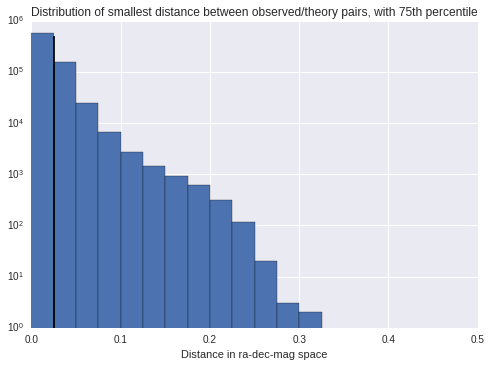

In [16]:
plt.hist(matched_input_idxs_and_dists[matched_input_idxs_and_dists[:,0]!=-1,1],bins = np.linspace(0,0.5,21));
plt.vlines(np.percentile(matched_input_idxs_and_dists[matched_input_idxs_and_dists[:,0]!=-1,1], [75]), 0, 5e5)
plt.yscale('log')
plt.xlabel('Distance in ra-dec-mag space')
plt.title('Distribution of smallest distance between observed/theory pairs, with 75th percentile')

In [16]:
mask = matched_input_idxs_and_dists[:,1] <= \
        np.percentile(matched_input_idxs_and_dists[matched_input_idxs_and_dists[:,0]!=-1,1], 75)

In [17]:
np.sum(mask)

578206

In [18]:
cut_output_data = output_data.iloc[mask]
cut_input_data = input_data.iloc[matched_input_idxs_and_dists[mask,0].astype(int)]

In [19]:
len(cut_output_data)

578206

In [20]:
cut_output_data.to_hdf('matched_output_data.hdf5', key = 'output1')
cut_input_data.to_hdf('matched_input_data.hdf5', key = 'input1')

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pandas/io/pytables.py:260: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  f(store)
/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pandas/io/pytables.py:260: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)
/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pandas/io/pytables.py:260: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_items] [items->None]

  f(store)
